In [ ]:
print("Installing required Python libraries...")
!pip install -U datasets
!pip install transformers>=4.41.0 datasets torch pandas numpy scikit-learn matplotlib seaborn accelerate bitsandbytes --quiet

Installing required Python libraries...


In [ ]:
# ==============================================================================
# UNVEILING MULTILINGUAL BIAS EMERGENCE ACROSS LLM LAYERS: EXPERIMENT 1
#
# This script provides a complete, modular implementation for Experiment 1:
# Layer-wise Bias Emergence Detection, as outlined in the research plan.
# Designed for Google Colab.
#
# Author: Gemini
# Date: 07 June 2024
# ==============================================================================

# ==============================================================================
# CELL 1: SETUP, AUTHENTICATION, AND DEPENDENCIES
# ==============================================================================
print("CELL 1: Setting up the environment...")

import os
import gc
import warnings
from tqdm.notebook import tqdm

# --- 1.1 Mount Google Drive ---
# This allows for persistent storage of models, datasets, and results.
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
    # Define base paths
    GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/Mult_LLM_Bias/"
    GDRIVE_RESULTS_PATH = os.path.join(GDRIVE_PROJECT_PATH, "Results/Experiment1/")
    HF_CACHE_DIR = os.path.join(GDRIVE_PROJECT_PATH, "hf_cache/")
    os.makedirs(GDRIVE_RESULTS_PATH, exist_ok=True)
    os.makedirs(os.path.join(GDRIVE_RESULTS_PATH, "plots"), exist_ok=True)
    os.makedirs(HF_CACHE_DIR, exist_ok=True)
    print(f"Project path set to: {GDRIVE_PROJECT_PATH}")

except ImportError:
    print("Not running in Google Colab. Using local paths.")
    GDRIVE_PROJECT_PATH = "./Mult_LLM_Bias/"
    GDRIVE_RESULTS_PATH = os.path.join(GDRIVE_PROJECT_PATH, "Results/Experiment1/")
    HF_CACHE_DIR = os.path.join(GDRIVE_PROJECT_PATH, "hf_cache/")
    os.makedirs(GDRIVE_RESULTS_PATH, exist_ok=True)
    os.makedirs(os.path.join(GDRIVE_RESULTS_PATH, "plots"), exist_ok=True)
    os.makedirs(HF_CACHE_DIR, exist_ok=True)


# --- 1.2 Suppress Warnings for Cleaner Output ---
warnings.filterwarnings("ignore")

# --- 1.3 Install Required Libraries ---
# Using --quiet to reduce installation log verbosity.
# print("Installing required Python libraries...")
#!pip install transformers>=4.41.0 datasets torch pandas numpy scikit-learn matplotlib seaborn accelerate bitsandbytes --quiet
# Note: The LogitLens4LLMs library from the plan is complex and focuses on logit analysis.
# For this experiment's goal (extracting layer embeddings), the standard `output_hidden_states`
# from Hugging Face Transformers is more direct, robust, and sufficient.
# We will use this standard method instead of the external library for better stability.
print("Library installation completed.")
all_results = []

# --- 1.4 Hugging Face Authentication ---
# Securely logs into Hugging Face using a token stored in Colab secrets.
print("Attempting to log in to Hugging Face...")
try:
    from huggingface_hub import login
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')

    if HF_TOKEN:
        login(HF_TOKEN, add_to_git_credential=True)
        print("Successfully logged in to Hugging Face!")
    else:
        print("Hugging Face token not found in Colab secrets. Please set it.")
except (ImportError, KeyError):
    print("Could not log in to Hugging Face. You may not be able to access gated models.")


# --- 1.5 Install Fonts for Hindi and Bengali Visualization ---
print("Installing fonts for Hindi and Bengali...")
!apt-get install -y fonts-noto-devanagari fonts-noto-bengali > /dev/null
print("Fonts installed.")

print("\nEnvironment setup complete.\n" + "="*80)


# ==============================================================================
# CELL 2: CORE COMPONENT CLASSES
#
# This section defines the classes that manage models, data, bias calculations,
# and results, keeping the code modular and reusable.
# ==============================================================================
print("CELL 2: Defining core component classes...")

import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties, findfont

# --- 2.1 LLMManager: Handles model loading, management, and memory ---

class LLMManager:
    """
    Manages the lifecycle of LLMs to optimize memory usage in Colab.
    - Loads models with 4-bit quantization for efficiency.
    - Unloads models to free up VRAM for the next experiment.
    """
    def __init__(self, cache_dir: str):
        self.cache_dir = cache_dir
        self.model = None
        self.tokenizer = None
        self.current_model_id = None
        print("LLMManager initialized.")

    def load_model(self, model_id: str):
        """Load model and tokenizer, return tuple of (model, tokenizer)"""
        if self.current_model_id == model_id and self.model is not None:
            print(f"Model '{model_id}' already loaded. Reusing existing instance.")
            return self.model, self.tokenizer

        # Find model configuration
        config = None
        for c in MODEL_CONFIGS:
            if c['model_id'] == model_id:
                config = c
                break

        if config is None:
            print(f"ERROR: Model configuration not found for '{model_id}'")
            return None, None

        print(f"Loading model: {model_id}")

        try:
            # Load tokenizer first
            self.tokenizer = AutoTokenizer.from_pretrained(
                model_id,
                cache_dir=self.cache_dir,
                trust_remote_code=True
            )

            # Set padding token if not present
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            # Load model with quantization
            quantization_config = BitsAndBytesConfig(load_in_4bit=True)

            self.model = AutoModelForCausalLM.from_pretrained(
                model_id,
                torch_dtype=config['torch_dtype'],
                device_map="auto",
                quantization_config=quantization_config,
                trust_remote_code=True,
                cache_dir=self.cache_dir
            )

            # Set current model ID
            self.current_model_id = model_id
            print(f"Model '{model_id}' loaded successfully.")

            return self.model, self.tokenizer

        except Exception as e:
            print(f"ERROR: Failed to load model '{model_id}'. Exception: {e}")
            self.model = None
            self.tokenizer = None
            self.current_model_id = None
            return None, None

    def unload_model(self):
        """Unloads the model and clears GPU cache."""
        if self.model:
            print(f"Unloading model: {self.current_model_id}...")
            del self.model
            del self.tokenizer
            self.model, self.tokenizer, self.current_model_id = None, None, None
            gc.collect()
            torch.cuda.empty_cache()
            print("Model unloaded and memory cleared.")
        else:
            print("No model to unload.")

    def get_model_layer_count(self):
        """Returns the number of hidden layers in the loaded model."""
        if self.model:
            return self.model.config.num_hidden_layers
        return 0



# --- 2.2 WEATHubLoader: Manages loading and access to the WEATHub dataset ---
# --- 2.2 WEATHubLoader: Manages loading and access to the WEATHub dataset ---
# --- 2.2 WEATHubLoader: Manages loading and access to the WEATHub dataset ---
class WEATHubLoader:
    """
    Loads the WEATHub dataset and provides word lists for specified languages and bias categories.
    Updated to correctly handle the actual dataset structure.
    """
    def __init__(self, dataset_id: str = "iamshnoo/WEATHub", cache_dir: str = None):
        print(f"Loading WEATHub dataset from '{dataset_id}'...")
        try:
            self.dataset = load_dataset(dataset_id, cache_dir=cache_dir, trust_remote_code=True)
            print("WEATHub dataset loaded successfully.")

            # Check available splits in the dataset
            print(f"Available splits: {list(self.dataset.keys())}")

            # Map test categories to their correct data split
            self.split_mapping = {
                # Original WEAT tests (WEAT1, WEAT2, WEAT6-WEAT9)
                'WEAT1': 'original_weat',
                'WEAT2': 'original_weat',
                'WEAT6': 'original_weat',
                'WEAT7': 'original_weat',
                'WEAT8': 'original_weat',
                'WEAT9': 'original_weat',
                # New human biases (WEAT11-WEAT15)
                'WEAT11': 'new_human_biases',
                'WEAT12': 'new_human_biases',
                'WEAT12B': 'new_human_biases',
                'WEAT13': 'new_human_biases',
                'WEAT13B': 'new_human_biases',
                'WEAT14': 'new_human_biases',
                'WEAT15': 'new_human_biases',
                # India-specific biases (WEAT16-WEAT26)
                'WEAT16': 'india_specific_biases',
                'WEAT17': 'india_specific_biases',
                'WEAT18': 'india_specific_biases',
                'WEAT19': 'india_specific_biases',
                'WEAT20': 'india_specific_biases',
                'WEAT21': 'india_specific_biases',
                'WEAT22': 'india_specific_biases',
                'WEAT23': 'india_specific_biases',
                'WEAT24': 'india_specific_biases',
                'WEAT25': 'india_specific_biases',
                'WEAT26': 'india_specific_biases'
            }

        except Exception as e:
            print(f"ERROR: Failed to load WEATHub dataset. Exception: {e}")
            self.dataset = None

        # Supported language codes
        self.language_codes = {'en', 'hi', 'bn', 'ar', 'ckb', 'da', 'de', 'el', 'es', 'fa', 'fr', 'it', 'ja', 'ko', 'ku', 'mr', 'pa', 'ru', 'te', 'th', 'tl', 'tr', 'ur', 'vi', 'zh'}

    def get_word_lists(self, language_code: str, weat_category_id: str):
        """
        Retrieves target and attribute word lists for a given language and WEAT category.
        Updated to handle the correct dataset field structure.
        """
        if not self.dataset:
            return None

        # Validate language code
        if language_code not in self.language_codes:
            print(f"Warning: Language code '{language_code}' not in supported languages: {self.language_codes}")
            return None

        # Determine which split to use based on the category
        if weat_category_id not in self.split_mapping:
            print(f"Warning: Category '{weat_category_id}' not found in supported categories.")
            return None

        split_name = self.split_mapping[weat_category_id]
        target_split = self.dataset[split_name]

        # Filter for the specific language and category
        try:
            filtered = target_split.filter(
                lambda x: x['language'] == language_code and x['weat'] == weat_category_id
            )

            if len(filtered) > 0:
                entry = filtered[0]

                # Access the fields using dot notation as they appear in the dataset
                # Check if all required fields exist and have valid examples
                required_fields = ['attr1.examples', 'attr2.examples', 'targ1.examples', 'targ2.examples']

                # Check field existence and validity
                for field in required_fields:
                    if field not in entry or not entry[field] or len(entry[field]) == 0:
                        print(f"Warning: Missing or empty field '{field}' for '{language_code}' and '{weat_category_id}'")
                        return None

                return {
                    'targ1': entry['targ1.examples'],
                    'targ2': entry['targ2.examples'],
                    'attr1': entry['attr1.examples'],
                    'attr2': entry['attr2.examples']
                }
            else:
                print(f"Warning: No data found for language '{language_code}' and category '{weat_category_id}' in split '{split_name}'.")
                return None

        except Exception as e:
            print(f"Error filtering data for '{weat_category_id}' in language '{language_code}': {e}")
            return None

    def list_available_data(self):
        """Helper method to see what data is actually available in the dataset."""
        if not self.dataset:
            print("Dataset not loaded.")
            return

        for split_name, split_data in self.dataset.items():
            print(f"\n--- Split: {split_name} ---")
            if len(split_data) > 0:
                # Show unique languages and WEAT categories
                languages = set()
                weat_categories = set()

                for example in split_data:
                    languages.add(example.get('language', 'N/A'))
                    weat_categories.add(example.get('weat', 'N/A'))

                print(f"Languages: {sorted(languages)}")
                print(f"WEAT Categories: {sorted(weat_categories)}")
            else:
                print("No data in this split.")

    def get_available_categories_for_language(self, language_code: str):
        """Get all available WEAT categories for a specific language."""
        if not self.dataset:
            return []

        available_categories = []
        for split_name, split_data in self.dataset.items():
            for example in split_data:
                if example.get('language') == language_code:
                    category = example.get('weat')
                    if category and category not in available_categories:
                        available_categories.append(category)

        return sorted(available_categories)

# --- 2.3 LayerEmbeddingExtractor: Extracts hidden states from model layers ---
class LayerEmbeddingExtractor:
    """Handles BFloat16 to float32 conversion before numpy operations"""
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = model.device

    @torch.no_grad()
    def get_embeddings(self, words: list, layer_idx: int):
        """Convert BFloat16 tensors to float32 before numpy conversion"""
        all_embeddings = []
        for word in words:
            inputs = self.tokenizer(word, return_tensors="pt", add_special_tokens=False)
            input_ids = inputs.input_ids.to(self.device)

            outputs = self.model(input_ids, output_hidden_states=True)
            layer_states = outputs.hidden_states[layer_idx]

            # Convert to float32 before moving to CPU
            word_embedding = layer_states[0].mean(dim=0).float().cpu().numpy()
            all_embeddings.append(word_embedding)

        return np.array(all_embeddings)

# --- 2.4 BiasQuantifier: Implements bias measurement metrics ---
class BiasQuantifier:
    """Calculates bias scores using WEAT effect size and projection-based methods."""

    def _s(self, w, A, B):
        """Helper function for WEAT: computes the association of a word w with attribute sets A and B."""
        mean_cos_A = np.mean([cosine_similarity([w], [a])[0][0] for a in A])
        mean_cos_B = np.mean([cosine_similarity([w], [b])[0][0] for b in B])
        return mean_cos_A - mean_cos_B

    def weat_effect_size(self, T1_embeds, T2_embeds, A1_embeds, A2_embeds):
        """Calculates the Word Embedding Association Test (WEAT) effect size (d-score)."""
        mean_T1 = np.mean([self._s(t, A1_embeds, A2_embeds) for t in T1_embeds])
        mean_T2 = np.mean([self._s(t, A1_embeds, A2_embeds) for t in T2_embeds])

        all_s = [self._s(t, A1_embeds, A2_embeds) for t in np.concatenate((T1_embeds, T2_embeds))]
        std_dev = np.std(all_s, ddof=1)

        return (mean_T1 - mean_T2) / std_dev if std_dev > 0 else 0

    def define_bias_subspace(self, A1_embeds, A2_embeds):
        """Defines a bias direction as the vector difference between the mean of two attribute sets."""
        return np.mean(A1_embeds, axis=0) - np.mean(A2_embeds, axis=0)

    def projection_bias_effect(self, T1_embeds, T2_embeds, bias_direction):
        """Calculates bias by projecting target embeddings onto the bias direction."""
        bias_direction_norm = bias_direction / np.linalg.norm(bias_direction)

        proj_T1 = np.mean([np.dot(t, bias_direction_norm) for t in T1_embeds])
        proj_T2 = np.mean([np.dot(t, bias_direction_norm) for t in T2_embeds])

        return proj_T1 - proj_T2

# --- 2.5 ResultsManager: Handles saving and visualizing results ---
class ResultsManager:
    """Manages saving results to CSV and generating plots with correct fonts."""
    def __init__(self, results_path: str):
        self.results_path = results_path
        self.plots_path = os.path.join(results_path, "plots")
        self.hindi_font = self._get_font('Noto Sans Devanagari')
        self.bengali_font = self._get_font('Noto Sans Bengali')
        print("ResultsManager initialized.")

    def _get_font(self, font_name):
        try:
            font_path = findfont(FontProperties(family=font_name))
            print(f"Found font '{font_name}' at: {font_path}")
            return FontProperties(fname=font_path)
        except ValueError:
            print(f"WARNING: Font '{font_name}' not found. Text may not render correctly.")
            return None

    def _get_lang_font_prop(self, language_code: str):
        if language_code == 'hi' and self.hindi_font:
            return self.hindi_font
        if language_code == 'bn' and self.bengali_font:
            return self.bengali_font
        return None

    def save_dataframe(self, df: pd.DataFrame, model_id: str):
        """Saves the results DataFrame to a CSV file."""
        filename = f"experiment1_results_{model_id.replace('/', '_')}.csv"
        filepath = os.path.join(self.results_path, filename)
        df.to_csv(filepath, index=False)
        print(f"Results successfully saved to: {filepath}")

    def plot_bias_progression(self, df, model_id, lang, weat_cat, metric):
        """Plots the progression of a bias metric across model layers."""
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))

        data = df[(df['language'] == lang) & (df['weat_category_id'] == weat_cat)]

        ax.plot(data['layer_idx'], data[metric], marker='o', linestyle='-', label=metric)
        ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Bias')

        font_prop = self._get_lang_font_prop(lang)

        ax.set_title(f"Bias Progression: {metric}\n{model_id} ({lang.upper()}) - {weat_cat}", fontproperties=font_prop)
        ax.set_xlabel("Transformer Layer Index")
        ax.set_ylabel(f"Bias Score ({metric})")
        ax.legend()

        filename = f"{model_id.replace('/', '_')}_{lang}_{weat_cat}_{metric}.png"
        filepath = os.path.join(self.plots_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {filepath}")
        plt.show()
        plt.close(fig)

    def plot_comparative_progression(self, df, model_id, langs_to_compare, weat_cat, metric):
        """Plots a comparison of bias progression across different languages."""
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))

        for lang in langs_to_compare:
            data = df[(df['language'] == lang) & (df['weat_category_id'] == weat_cat)]
            if not data.empty:
                ax.plot(data['layer_idx'], data[metric], marker='o', linestyle='-', label=f"{lang.upper()}")

        ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Bias')
        ax.set_title(f"Comparative Bias Progression: {metric}\n{model_id} - {weat_cat}")
        ax.set_xlabel("Transformer Layer Index")
        ax.set_ylabel(f"Bias Score ({metric})")
        ax.legend()

        filename = f"COMPARE_{model_id.replace('/', '_')}_{'_'.join(langs_to_compare)}_{weat_cat}_{metric}.png"
        filepath = os.path.join(self.plots_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Comparative plot saved to: {filepath}")
        plt.show()
        plt.close(fig)

    def plot_bias_heatmap(self, df, model_id, lang, metric):
        """Generates a heatmap of bias scores across layers and WEAT categories."""
        plt.style.use('seaborn-v0_8-whitegrid')

        data = df[df['language'] == lang]
        if data.empty:
            print(f"No data to plot heatmap for {model_id} in {lang}.")
            return

        pivot_table = data.pivot_table(index='layer_idx', columns='weat_category_id', values=metric)

        fig, ax = plt.subplots(figsize=(14, 10))
        sns.heatmap(pivot_table, ax=ax, cmap="coolwarm", center=0)

        font_prop = self._get_lang_font_prop(lang)
        ax.set_title(f"Bias Heatmap: {metric}\n{model_id} ({lang.upper()})", fontproperties=font_prop)
        ax.set_xlabel("WEAT Category")
        ax.set_ylabel("Transformer Layer Index")

        plt.xticks(rotation=45, ha='right')

        filename = f"HEATMAP_{model_id.replace('/', '_')}_{lang}_{metric}.png"
        filepath = os.path.join(self.plots_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {filepath}")
        plt.show()
        plt.close(fig)

    def display_summary_table(self, df: pd.DataFrame, model_id: str, language: str):
        """Displays a summary table of findings."""
        print("\n" + "="*30)
        print(f"RESULTS SUMMARY: {model_id} ({language.upper()})")
        print("="*30)

        lang_df = df[df['language'] == language]
        if lang_df.empty:
            print("No results to summarize.")
            return

        for weat_cat in lang_df['weat_category_id'].unique():
            cat_df = lang_df[lang_df['weat_category_id'] == weat_cat]

            # Find layer with max absolute bias
            max_weat_layer = cat_df.loc[cat_df['weat_score'].abs().idxmax()]
            max_proj_layer = cat_df.loc[cat_df['projection_bias'].abs().idxmax()]

            print(f"\n--- WEAT Category: {weat_cat} ---")
            print(f"  Max WEAT Score:      {max_weat_layer['weat_score']:.3f} (at Layer {int(max_weat_layer['layer_idx'])})")
            print(f"  Max Projection Bias: {max_proj_layer['projection_bias']:.3f} (at Layer {int(max_proj_layer['layer_idx'])})")

print("Core component classes defined.\n" + "="*80)


# ==============================================================================
# CELL 3: EXPERIMENT RUNNER CLASS
# ==============================================================================
print("CELL 3: Defining the experiment runner class...")

class BiasExperimentRunner:
    """Orchestrates the entire bias detection experiment for a given model."""
    def __init__(self, llm_manager, weathub_loader, bias_quantifier, results_manager):
        self.llm_manager = llm_manager
        self.weathub_loader = weathub_loader
        self.bias_quantifier = bias_quantifier
        self.results_manager = results_manager
        print("BiasExperimentRunner initialized.")

    def run_experiment_for_model(self, model_config: dict):
        """
        Executes the full layer-wise bias analysis for a single model configuration.
        """
        model_id = model_config['model_id']
        languages = model_config['languages']
        weat_categories = model_config['weat_categories']

        print(f"\n{'='*60}")
        print(f"Starting experiment for: {model_id}")
        print(f"Languages: {languages}")
        print(f"WEAT Categories: {weat_categories}")
        print(f"{'='*60}")

        # --- Load Model with Error Handling ---
        try:
            model, tokenizer = self.llm_manager.load_model(model_id)
            if model is None or tokenizer is None:
                print(f"ERROR: Failed to load model '{model_id}'. Skipping experiment.")
                return None
        except Exception as e:
            print(f"ERROR: Exception during model loading for '{model_id}': {e}")
            return None

        num_layers = self.llm_manager.get_model_layer_count()
        print(f"Model has {num_layers} layers.")

        if num_layers == 0:
            print("ERROR: Unable to determine number of layers. Skipping experiment.")
            self.llm_manager.unload_model()
            return None

        embedding_extractor = LayerEmbeddingExtractor(model, tokenizer)
        # all_results = []

        # --- Iterate through languages and categories ---
        for lang in languages:
            print(f"\n--- Processing Language: {lang} ---")

            for weat_cat in weat_categories:
                print(f"\nProcessing: Model='{model_id}', Lang='{lang}', Category='{weat_cat}'")

                try:
                    word_lists = self.weathub_loader.get_word_lists(lang, weat_cat)
                    if not word_lists or any(not lst for lst in word_lists.values()):
                        print(f"WARNING: Skipping '{weat_cat}' for '{lang}' due to missing word lists.")
                        continue

                    # Validate word lists have content
                    for key, words in word_lists.items():
                        if not words or len(words) == 0:
                            print(f"WARNING: Empty word list for '{key}' in '{weat_cat}' ({lang})")
                            break
                    else:
                        # All word lists are valid, proceed with layer analysis
                        layer_results = self._process_layers(
                            embedding_extractor, word_lists, model_id, lang, weat_cat, num_layers
                        )
                        all_results.extend(layer_results)

                except Exception as e:
                    print(f"ERROR: Exception processing '{weat_cat}' for '{lang}': {e}")
                    continue

        # --- Cleanup and Save ---
        self.llm_manager.unload_model()

        if not all_results:
            print(f"WARNING: No results generated for model {model_id}.")
            return None

        results_df = pd.DataFrame(all_results)
        self.results_manager.save_dataframe(results_df, model_id)
        print(f"Experiment completed for {model_id}. Generated {len(all_results)} result entries.")

        return results_df

    def _process_layers(self, embedding_extractor, word_lists, model_id, lang, weat_cat, num_layers):
        """Process all layers for a given language/category combination."""
        layer_results = []

        # --- Iterate through layers ---
        for layer_idx in tqdm(range(num_layers), desc=f"Layer Analysis ({lang}/{weat_cat})"):
            try:
                # Get embeddings for all word lists at the current layer
                t1_embeds = embedding_extractor.get_embeddings(word_lists['targ1'], layer_idx)
                t2_embeds = embedding_extractor.get_embeddings(word_lists['targ2'], layer_idx)
                a1_embeds = embedding_extractor.get_embeddings(word_lists['attr1'], layer_idx)
                a2_embeds = embedding_extractor.get_embeddings(word_lists['attr2'], layer_idx)

                # Validate embeddings
                if any(emb.size == 0 for emb in [t1_embeds, t2_embeds, a1_embeds, a2_embeds]):
                    print(f"WARNING: Empty embeddings at layer {layer_idx} for {lang}/{weat_cat}")
                    continue

                # Calculate bias scores
                weat_score = self.bias_quantifier.weat_effect_size(t1_embeds, t2_embeds, a1_embeds, a2_embeds)
                bias_direction = self.bias_quantifier.define_bias_subspace(a1_embeds, a2_embeds)
                proj_bias = self.bias_quantifier.projection_bias_effect(t1_embeds, t2_embeds, bias_direction)

                layer_results.append({
                    'model_id': model_id,
                    'language': lang,
                    'weat_category_id': weat_cat,
                    'layer_idx': layer_idx,
                    'weat_score': weat_score,
                    'projection_bias': proj_bias
                })

            except Exception as e:
                print(f"ERROR: Exception at layer {layer_idx} for {lang}/{weat_cat}: {e}")
                continue

        return layer_results

# ==============================================================================
# CELL 4: MAIN EXECUTION WORKFLOW
# ==============================================================================
print("CELL 4: Starting the main execution workflow...")

# --- 4.1 Experiment Configuration ---
# Define the models and tests to run.
# WEAT categories from WEATHub:
# - WEAT6: Career vs. Family with Male vs. Female Names (Gender-Profession)
# - WEAT7: Math vs. Arts with Male vs. Female Terms (Gender-Academic)
# - WEAT8: Science vs. Arts with Male vs. Female Terms (Gender-Academic)
# - WEAT1: Flowers vs. Insects with Pleasant vs. Unpleasant (Valence)
# - INWEAT5 (India Specific): Upper Caste vs. Lower Caste names with Pleasant vs. Unpleasant
# Updated model configurations with correct WEAT categories

# Updated model configurations with more robust dtype handling

MODEL_CONFIGS = [
    {
        "model_id": "meta-llama/Llama-3.1-8B",
        "languages": ["en", "hi"],
        "weat_categories": ["WEAT1", "WEAT2", "WEAT6"],  # Removed WEAT16 as it might not be available
        "torch_dtype": torch.float16  # More compatible than bfloat16
    },
    {
        "model_id": "BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1",
        "languages": ["en", "bn","hi"],
        "weat_categories": ["WEAT1", "WEAT2", "WEAT6"],
        "torch_dtype": torch.float16
    }
]

# MODEL_CONFIGS = [
#     {
#         "model_id": "meta-llama/Llama-3.1-8B",
#         "languages": ["en"],
#         "weat_categories": ["WEAT1"],  # Removed WEAT16 as it might not be available
#         "torch_dtype": torch.float16  # More compatible than bfloat16
#     },
#     {
#         "model_id": "BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1",
#         "languages": ["hi"],
#         "weat_categories": ["WEAT1"],
#         "torch_dtype": torch.float16
#     }
# ]



# --- 4.2 Initialize All Components ---
print("\nInitializing all components for the experiment...")
llm_manager = LLMManager(cache_dir=HF_CACHE_DIR)
weathub_loader = WEATHubLoader(cache_dir=os.path.join(HF_CACHE_DIR, "datasets"))
################################################
# Add this after initializing the WEATHubLoader to see what's actually available
print("\n=== DEBUGGING: Available data in WEATHub ===")
weathub_loader.list_available_data()

# Test specific combinations
test_combinations = [
    ("en", "WEAT1"), ("en", "WEAT6"),
    ("hi", "WEAT1"), ("bn", "WEAT1")
]

for lang, category in test_combinations:
    word_lists = weathub_loader.get_word_lists(lang, category)
    if word_lists:
        print(f"✓ Found data for {lang}/{category}")
    else:
        print(f"✗ No data for {lang}/{category}")
print("=" * 50)

###############################################
bias_quantifier = BiasQuantifier()
results_manager = ResultsManager(results_path=GDRIVE_RESULTS_PATH)

experiment_runner = BiasExperimentRunner(
    llm_manager, weathub_loader, bias_quantifier, results_manager
)
print("\nInitialization complete. Starting experiments...")

# --- 4.3 Run Experiments and Store Results ---
all_experiment_results = {}
for config in MODEL_CONFIGS:
    model_id = config['model_id']
    print("\n" + "#"*80)
    print(f"# Starting Experiment for Model: {model_id}")
    print("#"*80)

    try:
        results_df = experiment_runner.run_experiment_for_model(config)
        all_experiment_results[model_id] = results_df
        print(f"\nExperiment for {model_id} completed.")
        if results_df is not None:
            print("Sample of generated results:")
            print(results_df.head())
    except Exception as e:
        print(f"\nCRITICAL ERROR during experiment for {model_id}. Skipping. Error: {e}")
        llm_manager.unload_model() # Ensure cleanup even on failure
        all_experiment_results[model_id] = None

print("\n\nAll configured experiments have been run.")
print("="*80)


# ==============================================================================
# CELL 5: RESULTS VISUALIZATION AND SUMMARY
# ==============================================================================
# print("\nCELL 5: Generating visualizations and summaries from results...")

# for model_id, results_df in all_experiment_results.items():
#     if results_df is None or results_df.empty:
#         print(f"\nSkipping visualization for '{model_id}' due to no results.")
#         continue

#     print("\n" + "#"*80)
#     print(f"# Visualizing Results for Model: {model_id}")
#     print("#"*80)

#     # Get unique languages and categories that were successfully run
#     processed_configs = results_df[['language', 'weat_category_id']].drop_duplicates()

#     # --- Generate individual plots ---
#     for _, row in processed_configs.iterrows():
#         lang, weat_cat = row['language'], row['weat_category_id']
#         print(f"\n--- Plotting for Lang: {lang}, Category: {weat_cat} ---")
#         results_manager.plot_bias_progression(results_df, model_id, lang, weat_cat, 'weat_score')
#         results_manager.plot_bias_progression(results_df, model_id, lang, weat_cat, 'projection_bias')

#     # --- Generate heatmaps ---
#     for lang in results_df['language'].unique():
#         print(f"\n--- Plotting Heatmap for Lang: {lang} ---")
#         results_manager.plot_bias_heatmap(results_df, model_id, lang, 'weat_score')

#     # --- Generate comparative plots ---
#     # Example: Compare English and Hindi for the main Llama model
#     if 'en' in results_df['language'].unique() and 'hi' in results_df['language'].unique():
#         print("\n--- Plotting Comparative (EN vs HI) ---")
#         for weat_cat in results_df[results_df['language'] == 'hi']['weat_category_id'].unique():
#             results_manager.plot_comparative_progression(results_df, model_id, ['en', 'hi'], weat_cat, 'weat_score')

#     # Example: Compare English and Bengali for the BanglaLLM model
#     if 'en' in results_df['language'].unique() and 'bn' in results_df['language'].unique():
#         print("\n--- Plotting Comparative (EN vs BN) ---")
#         for weat_cat in results_df[results_df['language'] == 'bn']['weat_category_id'].unique():
#             results_manager.plot_comparative_progression(results_df, model_id, ['en', 'bn'], weat_cat, 'weat_score')

#     # --- Display Summary Tables ---
#     for lang in results_df['language'].unique():
#         results_manager.display_summary_table(results_df, model_id, lang)

# print("\n\n" + "="*80)
# print("Analysis complete. All results, plots, and summaries have been generated.")
# print(f"Check your Google Drive folder: {GDRIVE_RESULTS_PATH}")
# print("="*80)

CELL 1: Setting up the environment...
Mounted at /content/drive
Google Drive mounted successfully.
Project path set to: /content/drive/MyDrive/Mult_LLM_Bias/
Library installation completed.
Attempting to log in to Hugging Face...
Successfully logged in to Hugging Face!
Installing fonts for Hindi and Bengali...
E: Unable to locate package fonts-noto-devanagari
E: Unable to locate package fonts-noto-bengali
Fonts installed.

Environment setup complete.
CELL 2: Defining core component classes...
Core component classes defined.
CELL 3: Defining the experiment runner class...
CELL 4: Starting the main execution workflow...

Initializing all components for the experiment...
LLMManager initialized.
Loading WEATHub dataset from 'iamshnoo/WEATHub'...


README.md:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

(…)-00000-of-00001-7e85a83920777d87.parquet:   0%|          | 0.00/95.4k [00:00<?, ?B/s]

(…)-00000-of-00001-557150d939938864.parquet:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

(…)-00000-of-00001-a2b8ed74878afc1b.parquet:   0%|          | 0.00/24.6k [00:00<?, ?B/s]

Generating original_weat split:   0%|          | 0/150 [00:00<?, ? examples/s]

Generating new_human_biases split:   0%|          | 0/175 [00:00<?, ? examples/s]

Generating india_specific_biases split:   0%|          | 0/77 [00:00<?, ? examples/s]

WEATHub dataset loaded successfully.
Available splits: ['original_weat', 'new_human_biases', 'india_specific_biases']

=== DEBUGGING: Available data in WEATHub ===

--- Split: original_weat ---
Languages: ['ar', 'bn', 'ckb', 'da', 'de', 'el', 'en', 'es', 'fa', 'fr', 'hi', 'it', 'ja', 'ko', 'ku', 'mr', 'pa', 'ru', 'te', 'th', 'tl', 'tr', 'ur', 'vi', 'zh']
WEAT Categories: ['WEAT1', 'WEAT2', 'WEAT6', 'WEAT7', 'WEAT8', 'WEAT9']

--- Split: new_human_biases ---
Languages: ['ar', 'bn', 'ckb', 'da', 'de', 'el', 'en', 'es', 'fa', 'fr', 'hi', 'it', 'ja', 'ko', 'ku', 'mr', 'pa', 'ru', 'te', 'th', 'tl', 'tr', 'ur', 'vi', 'zh']
WEAT Categories: ['WEAT11', 'WEAT12', 'WEAT12B', 'WEAT13', 'WEAT13B', 'WEAT14', 'WEAT15']

--- Split: india_specific_biases ---
Languages: ['bn', 'en', 'hi', 'mr', 'pa', 'te', 'ur']
WEAT Categories: ['WEAT16', 'WEAT17', 'WEAT18', 'WEAT19', 'WEAT20', 'WEAT21', 'WEAT22', 'WEAT23', 'WEAT24', 'WEAT25', 'WEAT26']


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

✓ Found data for en/WEAT1


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

✓ Found data for en/WEAT6


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

✓ Found data for hi/WEAT1


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

✓ Found data for bn/WEAT1
Found font 'Noto Sans Devanagari' at: /usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
Found font 'Noto Sans Bengali' at: /usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf
ResultsManager initialized.
BiasExperimentRunner initialized.

Initialization complete. Starting experiments...

################################################################################
# Starting Experiment for Model: meta-llama/Llama-3.1-8B
################################################################################

Starting experiment for: meta-llama/Llama-3.1-8B
Languages: ['en', 'hi']
WEAT Categories: ['WEAT1', 'WEAT2', 'WEAT6']
Loading model: meta-llama/Llama-3.1-8B


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Model 'meta-llama/Llama-3.1-8B' loaded successfully.
Model has 32 layers.

--- Processing Language: en ---

Processing: Model='meta-llama/Llama-3.1-8B', Lang='en', Category='WEAT1'


Layer Analysis (en/WEAT1):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='meta-llama/Llama-3.1-8B', Lang='en', Category='WEAT2'


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Layer Analysis (en/WEAT2):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='meta-llama/Llama-3.1-8B', Lang='en', Category='WEAT6'


Layer Analysis (en/WEAT6):   0%|          | 0/32 [00:00<?, ?it/s]


--- Processing Language: hi ---

Processing: Model='meta-llama/Llama-3.1-8B', Lang='hi', Category='WEAT1'


Layer Analysis (hi/WEAT1):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='meta-llama/Llama-3.1-8B', Lang='hi', Category='WEAT2'


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Layer Analysis (hi/WEAT2):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='meta-llama/Llama-3.1-8B', Lang='hi', Category='WEAT6'


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Layer Analysis (hi/WEAT6):   0%|          | 0/32 [00:00<?, ?it/s]

Unloading model: meta-llama/Llama-3.1-8B...
Model unloaded and memory cleared.
Results successfully saved to: /content/drive/MyDrive/Mult_LLM_Bias/Results/Experiment1/experiment1_results_meta-llama_Llama-3.1-8B.csv
Experiment completed for meta-llama/Llama-3.1-8B. Generated 192 result entries.

Experiment for meta-llama/Llama-3.1-8B completed.
Sample of generated results:
                  model_id language weat_category_id  layer_idx  weat_score  \
0  meta-llama/Llama-3.1-8B       en            WEAT1          0   -0.633562   
1  meta-llama/Llama-3.1-8B       en            WEAT1          1   -0.476914   
2  meta-llama/Llama-3.1-8B       en            WEAT1          2   -0.361108   
3  meta-llama/Llama-3.1-8B       en            WEAT1          3   -0.306006   
4  meta-llama/Llama-3.1-8B       en            WEAT1          4   -0.245238   

   projection_bias  
0        -0.010614  
1        -0.135419  
2       -51.439148  
3       -51.430786  
4       -51.434357  

#######################

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Model 'BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1' loaded successfully.
Model has 32 layers.

--- Processing Language: en ---

Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='en', Category='WEAT1'


Layer Analysis (en/WEAT1):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='en', Category='WEAT2'


Layer Analysis (en/WEAT2):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='en', Category='WEAT6'


Layer Analysis (en/WEAT6):   0%|          | 0/32 [00:00<?, ?it/s]


--- Processing Language: bn ---

Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='bn', Category='WEAT1'


Layer Analysis (bn/WEAT1):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='bn', Category='WEAT2'


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Layer Analysis (bn/WEAT2):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='bn', Category='WEAT6'


Filter:   0%|          | 0/150 [00:00<?, ? examples/s]

Layer Analysis (bn/WEAT6):   0%|          | 0/32 [00:00<?, ?it/s]


--- Processing Language: hi ---

Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='hi', Category='WEAT1'


Layer Analysis (hi/WEAT1):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='hi', Category='WEAT2'


Layer Analysis (hi/WEAT2):   0%|          | 0/32 [00:00<?, ?it/s]


Processing: Model='BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1', Lang='hi', Category='WEAT6'


Layer Analysis (hi/WEAT6):   0%|          | 0/32 [00:00<?, ?it/s]

Unloading model: BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1...
Model unloaded and memory cleared.
Results successfully saved to: /content/drive/MyDrive/Mult_LLM_Bias/Results/Experiment1/experiment1_results_BanglaLLM_BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1.csv
Experiment completed for BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1. Generated 480 result entries.

Experiment for BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1 completed.
Sample of generated results:
                  model_id language weat_category_id  layer_idx  weat_score  \
0  meta-llama/Llama-3.1-8B       en            WEAT1          0   -0.633562   
1  meta-llama/Llama-3.1-8B       en            WEAT1          1   -0.476914   
2  meta-llama/Llama-3.1-8B       en            WEAT1          2   -0.361108   
3  meta-llama/Llama-3.1-8B       en            WEAT1          3   -0.306006   
4  meta-llama/Llama-3.1-8B       en            WEAT1          4   -0.245238   

   projection_bias  
0

--- Starting Comprehensive Analysis and Archival ---
Results will be saved in: /content/drive/MyDrive/Multilingual_Bias_Llama/results
Successfully created master DataFrame with 480 records.
Successfully saved all analysis to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/csv/master_bias_results_20250622_061530.csv
Saved Llama 3.1 results (en, hi) to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/csv/llama3_1_results_20250622_061530.csv
Saved BanglaLLama results (en, bn, hi) to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/csv/banglallama_results_20250622_061530.csv

--- Generating and Saving Visualizations ---
Saved WEAT progression plot to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/visualizations/layerwise_weat_20250622_061530.png


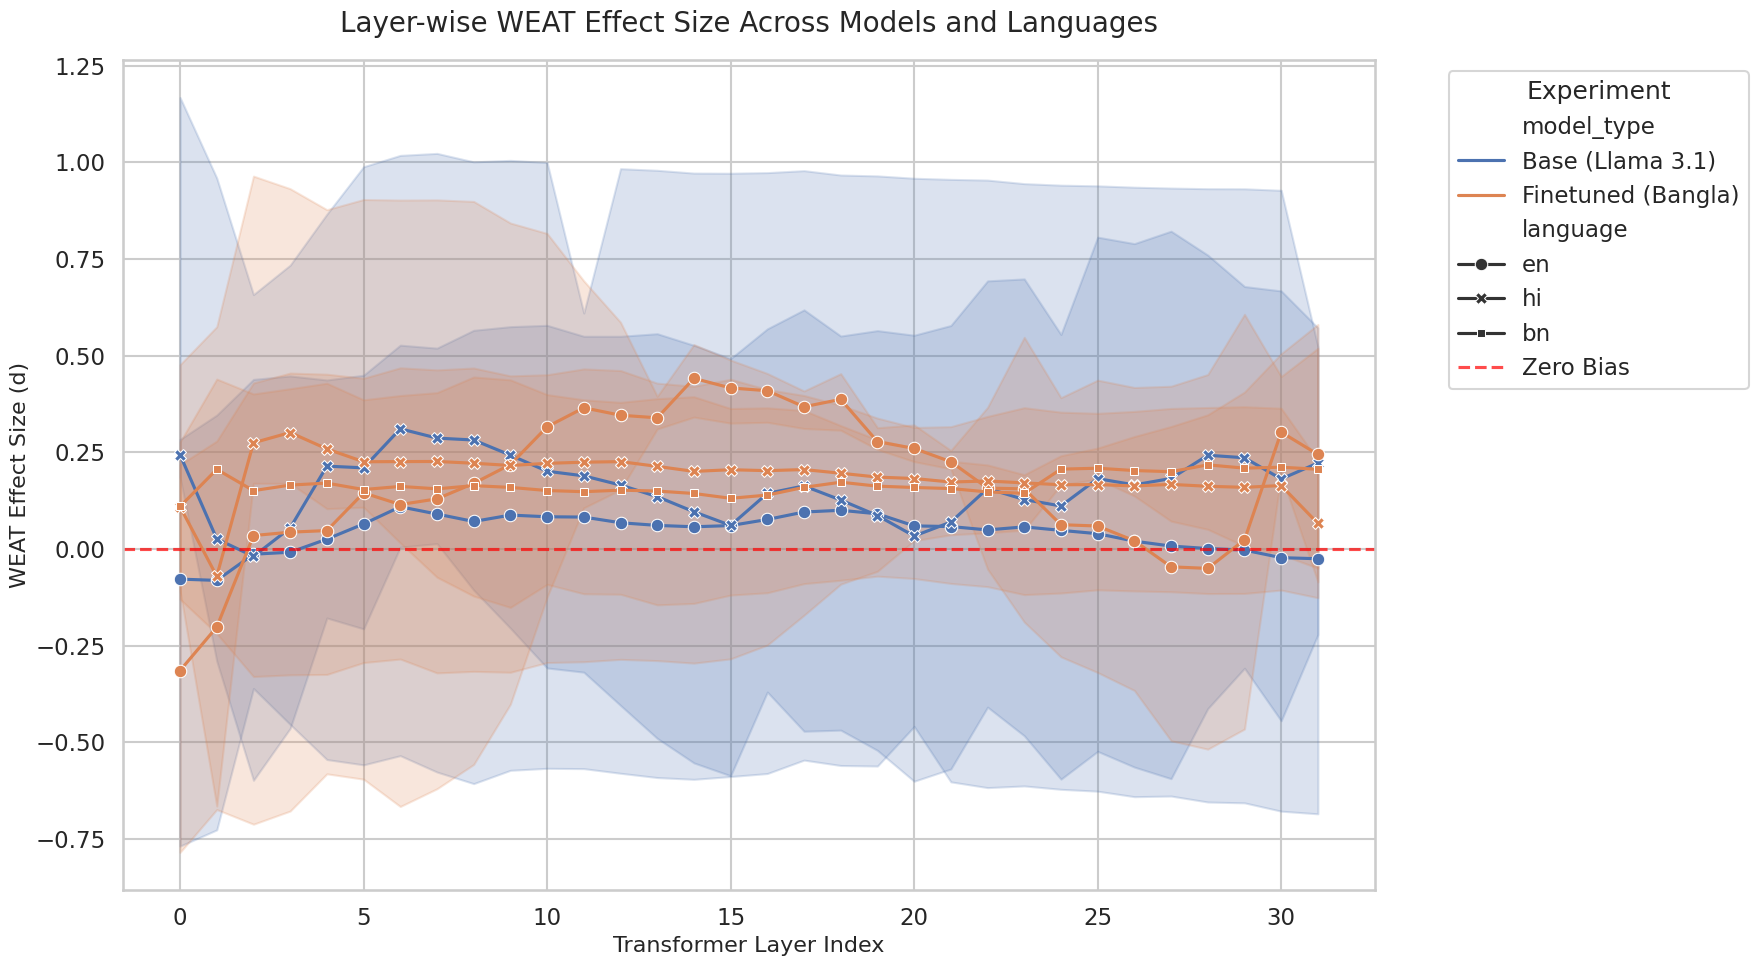

Saved Hindi comparison plot to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/visualizations/hindi_comparison_20250622_061530.png


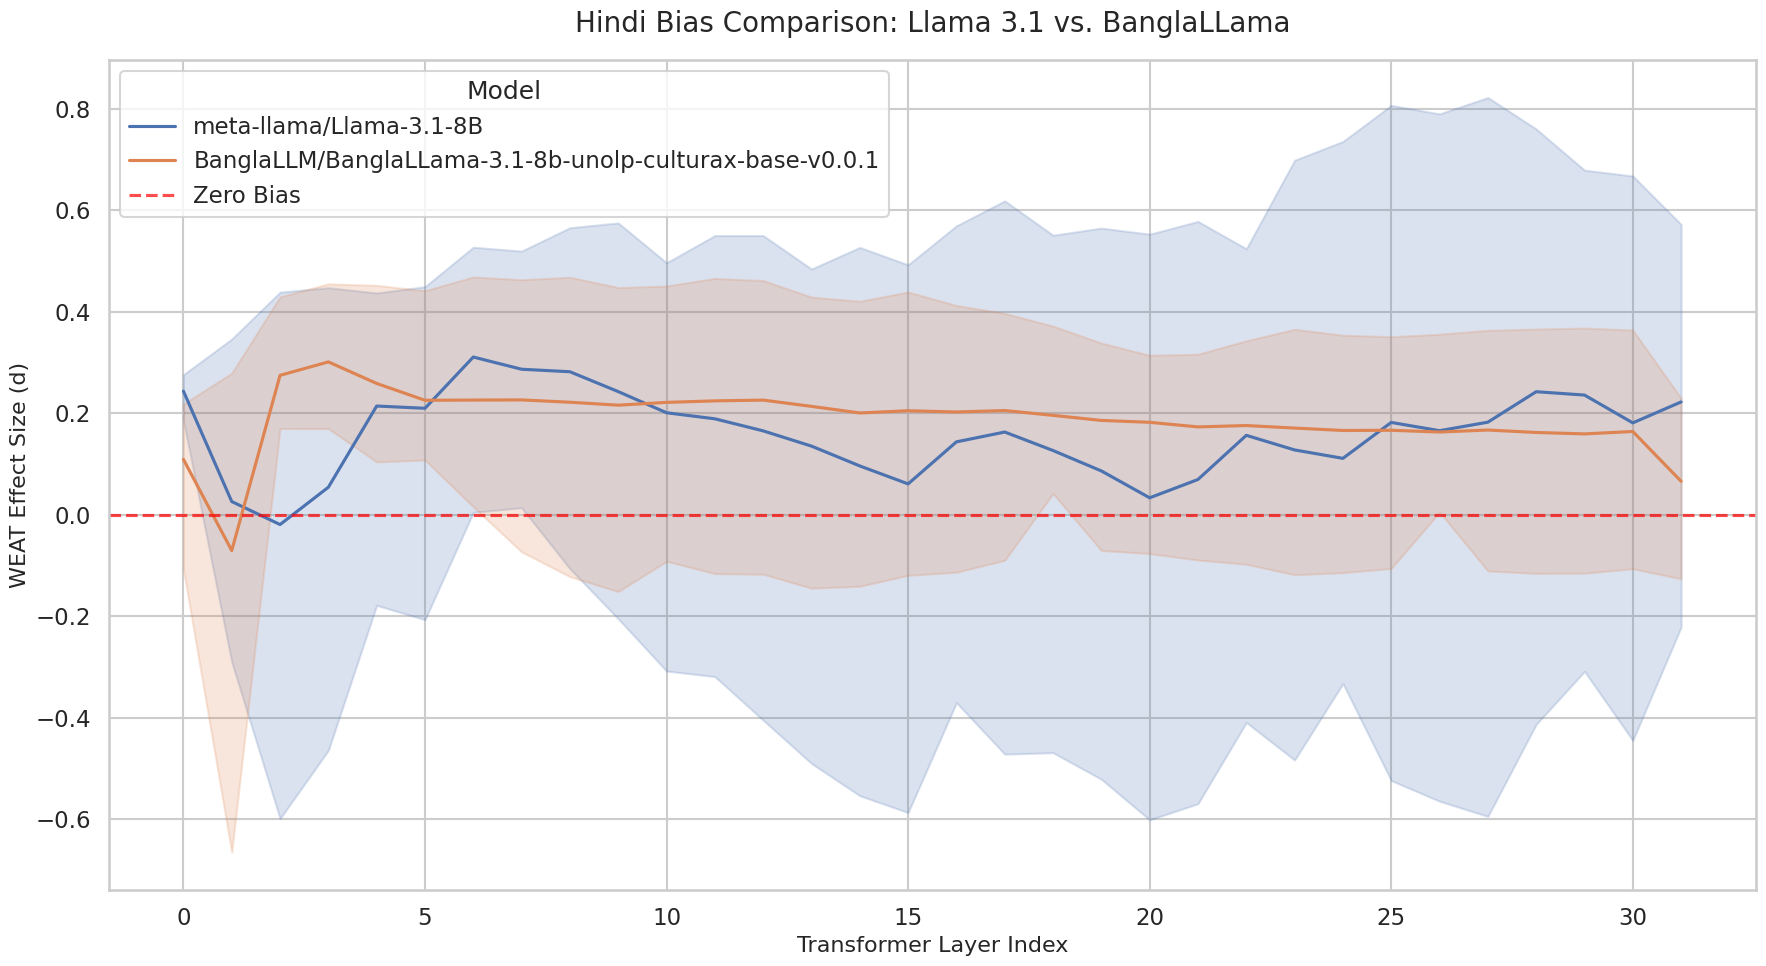


--- Summary of Bias at Final Layer ---
                                                    model_id          model_type language  weat_effect_size  projection_bias
319  BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1  Finetuned (Bangla)       bn             0.581         1.061000
223  BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1  Finetuned (Bangla)       en            -0.085       -15.104000
415  BanglaLLM/BanglaLLama-3.1-8b-unolp-culturax-base-v0.0.1  Finetuned (Bangla)       hi             0.230         8.564000
31                                   meta-llama/Llama-3.1-8B    Base (Llama 3.1)       en            -0.321       -50.730999
127                                  meta-llama/Llama-3.1-8B    Base (Llama 3.1)       hi             0.316        12.653000

Saved final layer summary table to: /content/drive/MyDrive/Multilingual_Bias_Llama/results/csv/final_layer_summary_20250622_061530.csv

--- Analysis and Archival Complete ---


In [ ]:
# CELL 5 (REVISED): COMPREHENSIVE RESULTS ANALYSIS, VISUALIZATION, AND ARCHIVAL

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("--- Starting Comprehensive Analysis and Archival ---")

# --- 1. SETUP: Define Paths for Storing Research Artifacts ---
# This structure ensures all results are organized and reproducible.
DRIVE_ROOT = "/content/drive/MyDrive/Multilingual_Bias_Llama"
RESULTS_DIR = os.path.join(DRIVE_ROOT, "results")
CSV_DIR = os.path.join(RESULTS_DIR, "csv")
VISUALIZATIONS_DIR = os.path.join(RESULTS_DIR, "visualizations")

# Create directories if they don't exist to prevent errors
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)

print(f"Results will be saved in: {RESULTS_DIR}")

# --- 2. DATA AGGREGATION AND STRUCTURING ---
# This step assumes 'all_results' is a list of dicts from the previous cell.
try:
    master_df = pd.DataFrame(all_results)
    print(f"Successfully created master DataFrame with {len(master_df)} records.")

    # --- Add a 'model_type' column for easier plotting ---
    # This is derived from the model_id string.
    def get_model_type(model_id):
        if "BanglaLLama" in model_id:
            return "Finetuned (Bangla)"
        elif "Llama-3.1-8B" in model_id:
            return "Base (Llama 3.1)"
        return "Unknown"

    master_df['model_type'] = master_df['model_id'].apply(get_model_type)

    # Standardize column names for clarity and compatibility with plotting code.
    master_df.rename(columns={
        'layer_idx': 'layer_index',
        'weat_score': 'weat_effect_size'
    }, inplace=True)

except NameError:
    print("ERROR: The 'all_results' variable was not found.")
    print("Please ensure the preceding cells have run correctly and generated results.")
    # Create a dummy DataFrame to prevent further errors in this cell
    master_df = pd.DataFrame()


if not master_df.empty:
    # --- 3. SAVE MASTER RESULTS FILE ---
    # This is the most critical step for data preservation.
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    MASTER_CSV_PATH = os.path.join(CSV_DIR, f"master_bias_results_{timestamp}.csv")
    master_df.to_csv(MASTER_CSV_PATH, index=False)
    print(f"Successfully saved all analysis to: {MASTER_CSV_PATH}")


    # --- 4. GENERATE AND SAVE SPECIFIC CSVs ---
    # Filter the master DataFrame to create specific subsets.

    # 4.1) Llama 3.1 Results (Hindi and English)
    llama3_df = master_df[
        master_df['model_id'].str.contains("Llama-3.1-8B", na=False) &
        master_df['language'].isin(['en', 'hi'])
    ]
    if not llama3_df.empty:
        LLAMA3_CSV_PATH = os.path.join(CSV_DIR, f"llama3_1_results_{timestamp}.csv")
        llama3_df.to_csv(LLAMA3_CSV_PATH, index=False)
        print(f"Saved Llama 3.1 results (en, hi) to: {LLAMA3_CSV_PATH}")
    else:
        print("No results found for Llama 3.1 to save.")

    # 4.2) BanglaLLama Results (Bengali, Hindi, and English)
    banglallama_df = master_df[
        master_df['model_id'].str.contains("BanglaLLama", na=False) &
        master_df['language'].isin(['en', 'bn', 'hi'])
    ]
    if not banglallama_df.empty:
        BANGLALLAMA_CSV_PATH = os.path.join(CSV_DIR, f"banglallama_results_{timestamp}.csv")
        banglallama_df.to_csv(BANGLALLAMA_CSV_PATH, index=False)
        print(f"Saved BanglaLLama results (en, bn, hi) to: {BANGLALLAMA_CSV_PATH}")
    else:
        print("No results found for BanglaLLama to save.")

    # --- 5. VISUALIZATION OF RESULTS ---
    print("\n--- Generating and Saving Visualizations ---")
    sns.set_theme(style="whitegrid", context="talk")

    # 5.1) Layer-wise WEAT Effect Size for all experiments
    plt.figure(figsize=(18, 10))
    sns.lineplot(
        data=master_df,
        x='layer_index',
        y='weat_effect_size',
        hue='model_type',
        style='language',
        markers=True,
        dashes=False
    )
    plt.title('Layer-wise WEAT Effect Size Across Models and Languages', fontsize=20, pad=20)
    plt.xlabel('Transformer Layer Index', fontsize=16)
    plt.ylabel('WEAT Effect Size (d)', fontsize=16)
    plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Bias')
    plt.legend(title='Experiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    VIZ_PATH_WEAT = os.path.join(VISUALIZATIONS_DIR, f"layerwise_weat_{timestamp}.png")
    plt.savefig(VIZ_PATH_WEAT, dpi=300, bbox_inches='tight')
    print(f"Saved WEAT progression plot to: {VIZ_PATH_WEAT}")
    plt.show()


    # 5.2) Comparative Analysis: Llama 3.1 vs. BanglaLLama on Hindi
    hindi_df = master_df[master_df['language'] == 'hi']
    if not hindi_df.empty:
        plt.figure(figsize=(18, 10))
        sns.lineplot(
            data=hindi_df,
            x='layer_index',
            y='weat_effect_size',
            hue='model_id',
            markers=True,
            dashes=False
        )
        plt.title('Hindi Bias Comparison: Llama 3.1 vs. BanglaLLama', fontsize=20, pad=20)
        plt.xlabel('Transformer Layer Index', fontsize=16)
        plt.ylabel('WEAT Effect Size (d)', fontsize=16)
        plt.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Bias')
        plt.legend(title='Model')
        plt.tight_layout()
        VIZ_PATH_HINDI = os.path.join(VISUALIZATIONS_DIR, f"hindi_comparison_{timestamp}.png")
        plt.savefig(VIZ_PATH_HINDI, dpi=300, bbox_inches='tight')
        print(f"Saved Hindi comparison plot to: {VIZ_PATH_HINDI}")
        plt.show()
    else:
        print("No Hindi data available for comparative plot.")


    # 5.3) Summary Table for Final Layer Bias
    final_layer_bias = master_df.loc[master_df.groupby(['model_id', 'language', 'model_type'])['layer_index'].idxmax()]
    # Select only the available columns for the summary
    summary_columns = ['model_id', 'model_type', 'language', 'weat_effect_size', 'projection_bias']
    final_layer_summary = final_layer_bias[summary_columns].round(3)

    print("\n--- Summary of Bias at Final Layer ---")
    print(final_layer_summary.to_string())

    SUMMARY_CSV_PATH = os.path.join(CSV_DIR, f"final_layer_summary_{timestamp}.csv")
    final_layer_summary.to_csv(SUMMARY_CSV_PATH, index=False)
    print(f"\nSaved final layer summary table to: {SUMMARY_CSV_PATH}")


print("\n--- Analysis and Archival Complete ---")
